In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchvision.models import get_model, get_model_weights, get_weight, list_models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image

from pathlib import Path
from PIL import ImageEnhance
from PIL import Image

import pandas as pd
from sklearn.metrics import confusion_matrix

from IPython.display import Video

from tqdm import tqdm

/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
batch_size = 100
learning_rate = 0.00025
epochs = 100

In [3]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

ref_path_original = basepath / 'data/reference_images/gender/'
ref_path_fully_blocked = basepath / 'data/reference_images/fully_blocked/'
ref_path_partially_blocked = basepath / 'data/reference_images/partially_blocked/'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True)
])

vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

ref_original_dataset = datasets.ImageFolder(ref_path_original, transform=transform)
ref_fully_blocked_dataset = datasets.ImageFolder(ref_path_fully_blocked, transform=transform)
ref_partially_blocked_dataset = datasets.ImageFolder(ref_path_partially_blocked, transform=transform)


figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

original_loader = torch.utils.data.DataLoader(ref_original_dataset, batch_size = 8, shuffle = True)
fully_blocked_loader = torch.utils.data.DataLoader(ref_fully_blocked_dataset, batch_size = 8, shuffle = True)
partially_blocked_loader = torch.utils.data.DataLoader(ref_partially_blocked_dataset, batch_size = 8, shuffle = True)

gender_dict = {0: "female", 1: "male"}

In [4]:
print(len(ref_original_dataset))


weights = get_model_weights("vgg16").DEFAULT
model = get_model("vgg16", weights=weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

8


In [5]:
model.classifier[6] = nn.Linear(4096, 2)

for i in range(0, 19):                
    for param in model.features[i].parameters():
        param.requires_grad = False

# Fine tuning last layers
for i in range(19, 30):
    for param in model.features[i].parameters():
        param.requires_grad = True

In [6]:
model = model.to(device)

In [7]:
savepath = "model_saves/base_model.pth"

In [8]:
# gender_balance = torch.tensor([1/386, 1/899])
# gender_balance = gender_balance.to(device)

# criterion = nn.CrossEntropyLoss(weight=gender_balance)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
# for epoch in tqdm(range(epochs)):
#     for i, (inputs, labels) in enumerate(train_loader):
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()

#         predictions = model(inputs)

#         # Get the output from the last layer
#         outputs = predictions

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

In [10]:
model.eval()

savepath = "model_saves/trained_model.pth"
torch.save(model.state_dict(), savepath)

In [11]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

In [12]:
predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.to(device)
        labels = labels.to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

Accuracy of the network on the 257 test images: 69 %


In [13]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Accuracy : 0.6964980363845825
Precision: 0.7464115023612976
Recall   : 0.8618784546852112
F1       : 0.800000011920929


# Compare performance of reference images (Unblocked, Partially Blocked, Fully Blocked)

In [24]:
## Unblocked

predicted_list = []
target_list = []
misclassified_images_unblocked = []

correct = 0
total = 0

with torch.no_grad():
    for data in original_loader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.to(device)
        labels = labels.to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        misclassified_indices_unblocked = (predicted != labels).nonzero().squeeze()
        for index in misclassified_indices_unblocked:
            misclassified_images_unblocked.append(images[index].cpu())

print(f'Accuracy of the network on the {str(len(ref_original_dataset))} unblocked reference images: {100 * correct / total} %')

## Partially Blocked
predicted_list = []
target_list = []
misclassified_images_partially = []

correct = 0
total = 0

with torch.no_grad():
    for data in partially_blocked_loader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.to(device)
        labels = labels.to(device)
        target_list += labels
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        misclassified_indices_partially = (predicted != labels).nonzero().squeeze()
        for index in misclassified_indices_partially:
            misclassified_images_partially.append(images[index].cpu())

print(f'Accuracy of the network on the {str(len(ref_partially_blocked_dataset))} partially blocked reference images: {100 * correct / total} %')

## Fully Blocked
predicted_list = []
target_list = []
misclassified_images_fully = []

correct = 0
total = 0

with torch.no_grad():
    for data in fully_blocked_loader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.to(device)
        labels = labels.to(device)
        target_list += labels
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        misclassified_indices_fully = (predicted != labels).nonzero().squeeze()
        for index in misclassified_indices_fully:
            misclassified_images_fully.append(images[index].cpu())

print(f'Accuracy of the network on the {str(len(ref_fully_blocked_dataset))} fully blocked reference images: {100 * correct / total} %')

Accuracy of the network on the 8 unblocked reference images: 100.0 %
Accuracy of the network on the 14 partially blocked reference images: 78.57142857142857 %
Accuracy of the network on the 8 fully blocked reference images: 62.5 %


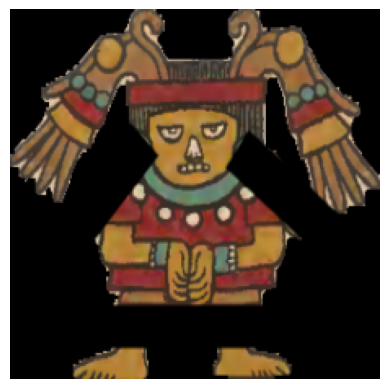

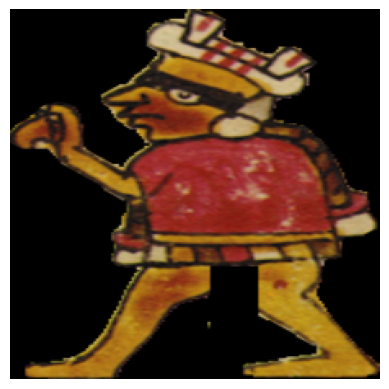

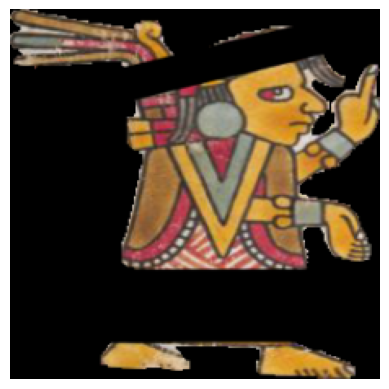

In [22]:
# Display misclassified images using matplotlib
def imshow(img):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for image in misclassified_images_fully:
    imshow(image.squeeze(0))

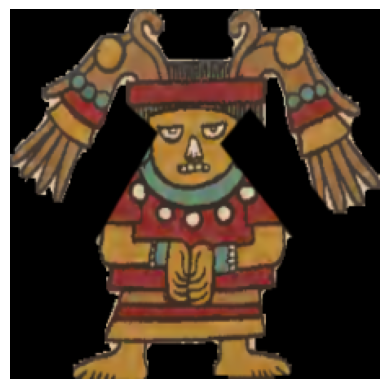

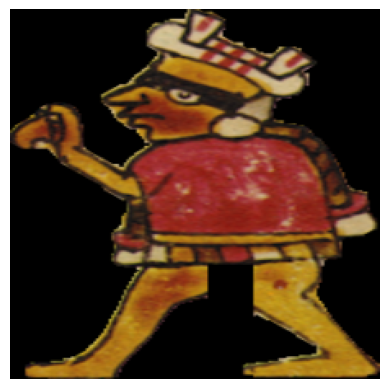

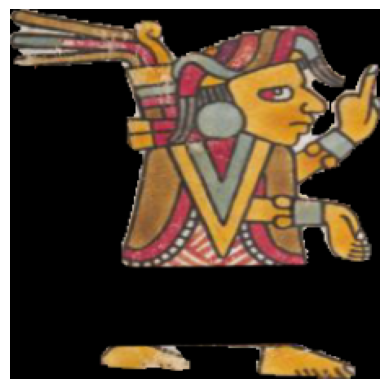

In [25]:
# Display misclassified images using matplotlib
def imshow(img):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for image in misclassified_images_partially:
    imshow(image.squeeze(0))

In [26]:
# Display misclassified images using matplotlib
def imshow(img):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for image in misclassified_images_unblocked:
    imshow(image.squeeze(0))